In [35]:
using PyPlot
using PyCall
@pyimport matplotlib.animation as anim
@pyimport matplotlib.patches as patches

In [36]:
using Base64
function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

showanim (generic function with 1 method)

In [93]:
mutable struct World
    objects
    debug
    ani
end

World() = World([], false, nothing)
World(debug) = World([], debug, nothing)

function append(self::World, obj)
    push!(self.objects, obj)
end

function init_draw(self::World, ax)
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
end

function draw(self::World)
    fig, ax = subplots()
    init_draw(self, ax)    
    elems = []

    if self.debug
        for i = 1:1000
            one_step(self, i, elems, ax)
        end
    else
        self.ani = anim.FuncAnimation(fig, one_step, fargs=(self, elems, ax), frames=37, interval=1000)
        self.ani[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    end 
    
end

function one_step(i,self::World,elems, ax)
    plt.cla()
    init_draw(self, ax)
    while length(elems) > 0
        pop!(elems)
    end
    vcat(elems, ax.text(-4.4, 4.5, "t = $i", fontsize=10))
    for obj in self.objects
        draw(obj, ax, elems)
        one_step(obj, 1.0)
    end
end

one_step (generic function with 2 methods)

In [94]:
mutable struct Agent
    nu
    omega
end
function decision(self::Agent, observation=nothing)
    return self.nu, self.omega
end

decision (generic function with 2 methods)

In [95]:
mutable struct IdealRobot
    pose
    r
    color
    agent
    poses
end

IdealRobot(pose) = IdealRobot(pose, 0.2, "black", nothing, [pose])
IdealRobot(pose, color) = IdealRobot(pose, 0.2, color, nothing, [])
IdealRobot(pose, agent) = IdealRobot(pose, 0.2, "black", agent, [pose])
IdealRobot(pose, agent, color) = IdealRobot(pose, 0.2, color, agent, [pose])

function draw(self::IdealRobot, ax, elems)
    x,y,theta = self.pose
    xn = x + self.r * cos(theta)
    yn = y + self.r * sin(theta)
    elems = vcat(elems, ax.plot([x, xn], [y,yn], color = self.color))
    c = patches.Circle(xy=(x,y), radius = self.r, fill = false, color = self.color)
    elems = vcat(elems, [ax.add_patch(c)])
    
    push!(self.poses, self.pose)
    elems = vcat(elems, ax.plot([e[1] for e in self.poses], [e[2] for e in self.poses], linewidth=0.5, color="black"))
end

function state_transition(self::IdealRobot, nu, omega, time)
    t0 = self.pose[3]
    if abs(omega) < 1e-10
        return self.pose + [nu*cos(t0), nu*sin(t0), omega].*time
    else
        return self.pose + [nu/omega*(sin(t0+omega*time)-sin(t0)),
                                  nu/omega*(-cos(t0+omega*time)+cos(t0)),
                                 omega*time]
    end
end

function one_step(self::IdealRobot, time_interval)
    if isnothing(self.agent)
        return
    end
    nu, omega = decision(self.agent)
    self.pose = state_transition(self, nu, omega, time_interval)
end

one_step (generic function with 2 methods)

In [96]:
robot1 = IdealRobot([0, 0, 0])

IdealRobot([0, 0, 0], 0.2, "black", nothing, [[0, 0, 0]])

In [97]:
state_transition(robot1, 0.1, 0.0, 1.0)

3-element Array{Float64,1}:
 0.1
 0.0
 0.0

In [98]:
state_transition(robot1, 0.1, 10.0/180*pi, 9.0)

3-element Array{Float64,1}:
 0.5729577951308232
 0.5729577951308231
 1.5707963267948966

In [99]:
state_transition(robot1, 0.1, 10.0/180*pi, 18.0)

3-element Array{Float64,1}:
 7.016709298534876e-17
 1.1459155902616465
 3.141592653589793

In [100]:
mutable struct Agent
    nu
    omega
end
function decision(self::Agent, observation=nothing)
    return self.nu, self.omega
end

decision (generic function with 2 methods)

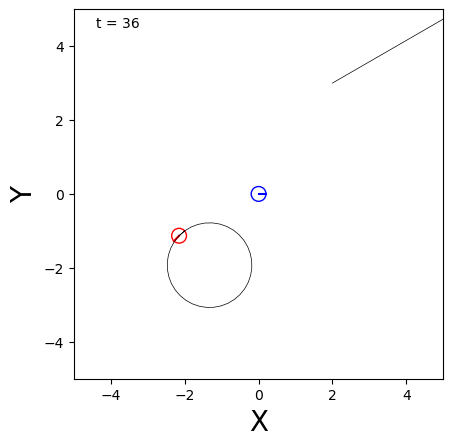

In [101]:
world = World()
straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*pi)
robot1 = IdealRobot([2, 3, pi/6], straight)
robot2 = IdealRobot([-2, -1, pi/5*6], circling, "red")
robot3 = IdealRobot([0,0,0], nothing, "blue")
append(world, robot1)
append(world, robot2)
append(world, robot3)
draw(world)

In [102]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAWLhtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADotliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQke2X0usXqfPiDEebvqajdAR0IXLJkGKVHOT7dYTgSPXqtuKwKpd7bOdwXFUKz3vq2bE3cQtYlDiWGR63clsbBB+lOl5LTyglzq27fAZ4QaN4zRJbaFhv5YSDoW3PmtZRPc4yOxfkBGtqp/lT3dCi/ZVOiVef8sT+TnFZToOjunYMB9SpTcmgfdozasgeaf6MKgA/b36mnN1E94hL6cOWdZciSxuKuDEnVtFkbA8VBuIYpwWmGSCU/KyoFCP853gqqjoPGwAclSiTi8Xocnd6XrQybRiEX7OnnXNntVcfCC/Ea0fjbwfl2o9ts0x7G4UWvyqe7yzq3oN+WeE93hG+uIdEPbna2Lpgeb2mAGXdEbueysG5mpC7yeEF3Kuh9DiOp48zAAKAk+OYB8JkIgp24BPi2SK3Idq0I9GorXJQPOlwjXywqcUGLX2JguWieyYssrNZcOFTGRH8j9ijLI7iew1i8GyhFFC8iTCAkvorXwF/B4/0xLCQjBxlUT3CimtgvZTf/TLsupiZZC6F/ixLHvCdfc4O8je13mNVWZXCr9vLr8S6kRivgtvThXHDmcJDltzB4b6l2SfksHCiaYA6oZFeAVqv7RjTWAyApH2b5RjQfdP3Wix2oWwGgWaX82EfTd1nBL6zplrtelX5hbVUh/BlJBc1/O4BghYToP16VrB1cCPnJrmja9Cx/xcDBnd2sW7VRTA8tzxSKHW0RbN9bEGODP5GZDTZc8kjN1jjyTMInCTYcf0U7n+Qe4HovGt3qAadmdQYYzBxfveRZe9sur3Xa7aZ/N5JV88TwjBI08MC4UR0hVBLPlirGd84++D3g/jU419a6ve+UhW0sbMDdYwmzuq4ZHaRGk0STUeMqP0xdkqFZdFbl6YlsqAMnbWFjqbnNJX1U6R6S0eEg3c7FXCbYhCBhrJFRjVsETlDtmeKidWDk/8Tf5dezmfXKDO/U3YFzvoEJisEJ1/s9wqMXWMDOE5/sRqtHX2Sq9OZ74fuadp9eYVU7dxa94Hevd4s2TZjBDGwXjXndKYxbLWRDctckVTSgzyAiuZmdGfcFMFwHgBzOvK8pw5CIxDAOY2jTFaKVfB5NeDYSH4yh+bfQDb4EqBRIJT4Y5gfmFaqEkQs3ILgjMDwG2hOWwEXhNpGt/8ksxk+bhIVB4EwEoLObnoqThmtxRvWCK8AoNGixckb2dn91Ctdbgy9FA9my1tJAQkrHgIhRs3kFsVnETU89hDMpOm2CZ1H1i3+7WoHsYELpHT27eKJ2QnXhGa8gKvLL33QWk89hTHqtqDQx2Z8V6/eIP/CGxJ4xyPhHKPLzm5AmUI5kFW+TGffEAm+57+AQ9sn39gDF2wbP9Tj2KMu+5zCBX44qRNre+qRL7wyt7w1u6NWK/AURO3dT/2PjDDh6/9TlPtQMP0cQHf5la8IW/EZb05rhEdn3ZZLCo/pgb1uldzPRm9vlwLB87GPv2X6mLvgthAL5REP2r7GlHyk7bOF1297hLvxtqkFvkDdxTGICiKFE2roLH9Gmqzq93h5LzydvoxyYOfHIuFVk+XPK1zQPoNUwF9v/83WqRf1XDdFsJDEf/Wb7qlwV+M8KHX+DA7EB6vnh9X4oV2aIkbdSQoMzRLwkoH+g3u8POzxBznQSmEpGbcDJ8Ey4Mp76qPsntmtOxykg90Sy35AWhuMpY6/i9USOYGSUmzV5drVKpwWIkJ00l+JZouWKFypHD83JDGUV1HHLwcSP/3XMCcsqtdEYIdXs9kLBVAU/CrcasquQx38sz4kiEjhHVTaAJIZPm6c1UKpU0V+tikj2/6MLM6c8vQ55WvojdIKDsit8Uco0U0V34ijimZpb7F8loiOCUExzgKlS4pBztzh8YVmS5e27zBDRvGJso6tduol44OS4oxUVRhcjaBaAnyu/+Lg4ZsGSh/3gslJQ6GoTMUI/87njo7+CQrGR2KE4iCJc3st5Z6PKy7U6MqMpeNi9Aq4rhX9dbSBfVcqNXflkwz5VZ1iuv9pydJhpL7gwv/3RHKyjczgz/yduo0WF4HL5XwafFvzd612R4opHS9A1leSvlclQzlxz9TkNh6cXUjwOVDBZUY4ZeDD7Q/2krvg62gzj1PDONqTwj0uq7WxK4iAL+37j40Ep/RU5VJF1ksIK6ewzYtrRj//s0Am+aKAsfCGNlUe3+kDS/qzxia+F8pSh+2F6ge1fjSdP0wPKm/hYYK7BXRn4UYjm5x+tq/2rijpfguzKEUuMgzr+8Bg2ei7sIkFHUv6a7kB22jKcyKH3+GokW2S8LXlX3M8q3PQ2IBdwcOEEZDymJ7qEofBepGtMIlwh/K8YNp41ozCX9y3CQhrLTsbYLgBB1sdBJ070bbp3zN4X5j2r2lT2RHRd4491fFe9p7u9viTSgAdou6GmeN7glk67SyqZImqgWGXRZiGJJ5ffP2WYSH5H1FwZ0IVYTt62kdEkI4mUd3xd1Bgb9VyygpCjn3wTScQ+wA9/uH+3n4tu0TEpsxhz+vHq+16H8aN9j/mAaY9smvIhuoImFOFU68RCzF6Wl9ITK+nJ6fa+Gvh8WGuIHK4tWUQoR2/HwTuhfK0k5cHlBJHJpsoMulF3shkDTF7l8/o9ea0lUD4bvTFGQ0DlOAtSb9GlktmzFX5QzAJjCwi2mcw1ux9wGGY1j5F6AE7D8HonUjWgzXRXQPkPENUAKIoAN4WgzIu46RUZLbyL6f8D2aAn8U0Ue/R+0UljLNzdSFwrizSxDfwo24UnxXL3CNEavMDbSoBjYRQf9bzaCX1dg0wYLaA2wUy6Lqbz9WcO9eqcfVwYmpnv6IpO5Cox194aFDXOaFHmbaeGxD2rqmEPHaqLZlNY+k40/Xzr6c